Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.7.1
IPython 7.2.0

torch 1.0.0


# Model Zoo -- Using PyTorch Dataset Loading Utilities for Custom Datasets (Cropped Street View Hous Numbers, SVHN)

This notebook provides an example for how to load an image dataset, stored as individual PNG files, using PyTorch's data loading utilities. For a more in-depth discussion, please see the official

- [Data Loading and Processing Tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html)
- [torch.utils.data](http://pytorch.org/docs/master/data.html) API documentation

In this example, we are using the cropped version of the **Street View House Numbers (SVHN) Dataset**, which is available at http://ufldl.stanford.edu/housenumbers/. 

To execute the following examples, you need to download the 2 ".mat" files 

- [train_32x32.mat](http://ufldl.stanford.edu/housenumbers/train_32x32.mat) (ca. 182 Mb, 73,257 images)
- [test_32x32.mat](http://ufldl.stanford.edu/housenumbers/test_32x32.mat) (ca. 65 Mb, 26,032 images)




## Imports

In [2]:
import pandas as pd
import numpy as np
import os

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image
import scipy.io as sio
import imageio

## Dataset

The following function will convert the images from ".mat" into individual ".png" files. In addition, we will create CSV contained the image paths and associated class labels.

In [3]:
def make_pngs(main_dir, mat_file, label):
    
    if not os.path.exists(main_dir):
        os.mkdir(main_dir)
        
    sub_dir = os.path.join(main_dir, label)
    if not os.path.exists(sub_dir):
        os.mkdir(sub_dir)

    data = sio.loadmat(mat_file)

    X = np.transpose(data['X'], (3, 0, 1, 2))
    y = data['y'].flatten()

    with open(os.path.join(main_dir, '%s_labels.csv' % label), 'w') as out_f:
        for i, img in enumerate(X):
            file_path = os.path.join(sub_dir, str(i) + '.png')
            imageio.imwrite(os.path.join(file_path),
                            img)

            out_f.write("%d.png,%d\n" % (i, y[i]))

            
make_pngs(main_dir='svhn_cropped',
          mat_file='train_32x32.mat',
          label='train')
    
    
make_pngs(main_dir='svhn_cropped',
          mat_file='test_32x32.mat',
          label='test')

In [4]:
df = pd.read_csv('svhn_cropped/train_labels.csv', header=None, index_col=0)
df.head()

,1
0,
0.png,1
1.png,9
2.png,2
3.png,3
4.png,2


In [5]:
df = pd.read_csv('svhn_cropped/test_labels.csv', header=None, index_col=0)
df.head()

,1
0,
0.png,5
1.png,2
2.png,1
3.png,10
4.png,6


## Implementing a Custom Dataset Class

Now, we implement a custom `Dataset` for reading the images. The `__getitem__` method will

1. read a single image from disk based on an `index` (more on batching later)
2. perform a custom image transformation (if a `transform` argument is provided in the `__init__` construtor)
3. return a single image and it's corresponding label

In [6]:
class SVHNDataset(Dataset):
    """Custom Dataset for loading cropped SVHN images"""
    
    def __init__(self, csv_path, img_dir, transform=None):
    
        df = pd.read_csv(csv_path, index_col=0, header=None)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df[1].values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

Now that we have created our custom Dataset class, let us add some custom transformations via the `transforms` utilities from `torchvision`, we

1. normalize the images (here: dividing by 255)
2. converting the image arrays into PyTorch tensors

Then, we initialize a Dataset instance for the training images using the 'quickdraw_png_set1_train.csv' label file (we omit the test set, but the same concepts apply).

Finally, we initialize a `DataLoader` that allows us to read from the dataset.

In [7]:
# Note that transforms.ToTensor()
# already divides pixels by 255. internally

custom_transform = transforms.Compose([#transforms.Grayscale(),                                       
                                       #transforms.Lambda(lambda x: x/255.),
                                       transforms.ToTensor()])

train_dataset = SVHNDataset(csv_path='svhn_cropped/train_labels.csv',
                              img_dir='svhn_cropped/train',
                              transform=custom_transform)

test_dataset = SVHNDataset(csv_path='svhn_cropped/test_labels.csv',
                             img_dir='svhn_cropped/test',
                             transform=custom_transform)

BATCH_SIZE=128


train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=4)

That's it, now we can iterate over an epoch using the train_loader as an iterator and use the features and labels from the training dataset for model training:

## Iterating Through the Custom Dataset

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


Just to make sure that the batches are being loaded correctly, let's print out the dimensions of the last batch:

In [9]:
x.shape

torch.Size([128, 3, 32, 32])

As we can see, each batch consists of 128 images, just as specified. However, one thing to keep in mind though is that
PyTorch uses a different image layout (which is more efficient when working with CUDA); here, the image axes are "num_images x channels x height x width" (NCHW) instead of "num_images height x width x channels" (NHWC):

To visually check that the images that coming of the data loader are intact, let's swap the axes to NHWC and convert an image from a Torch Tensor to a NumPy array so that we can visualize the image via `imshow`:

In [10]:
one_image = x[99].permute(1, 2, 0)
one_image.shape

torch.Size([32, 32, 3])

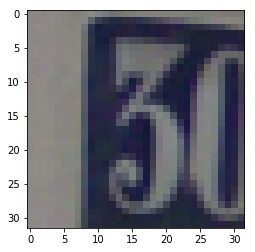

In [11]:
# note that imshow also works fine with scaled
# images in [0, 1] range.
plt.imshow(one_image.to(torch.device('cpu')));

In [12]:
%watermark -iv

torch       1.0.0
pandas      0.23.4
imageio     2.4.1
numpy       1.15.4
torchvision 0.2.1
scipy       1.1.0
PIL.Image   5.3.0
matplotlib  3.0.2

